# Airbnb NYC Data Analysis

This notebook analyzes the uploaded Airbnb NYC dataset (`/content/1730285881-Airbnb_Open_Data.xlsx`) to answer the research questions provided. It uses `pandas` for data handling and `matplotlib` for visualization. Run the cells sequentially. If the filename differs, update the `DATA_PATH` variable in the first code cell.

In [3]:
# Imports and constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = '/content/1730285881-Airbnb_Open_Data.xlsx'  # path to uploaded file
OUTPUT_NOTEBOOK = '/mnt/data/airbnb_nyc_analysis.ipynb'

print("Notebook will load:", DATA_PATH)

Notebook will load: /content/1730285881-Airbnb_Open_Data.xlsx


In [4]:
# Load the Excel file (attempt to auto-detect sheet with main data)
xls = pd.ExcelFile(DATA_PATH)
print('Sheets found:', xls.sheet_names)
# Heuristics: pick the largest sheet by rows as main table
sheet_lengths = {s: len(xls.parse(s)) for s in xls.sheet_names}
main_sheet = max(sheet_lengths, key=sheet_lengths.get)
print('Selecting sheet:', main_sheet)
df = xls.parse(main_sheet)

print('\nLoaded dataframe shape:', df.shape)
df.head()

Sheets found: ['in']
Selecting sheet: in

Loaded dataframe shape: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [5]:
# Initial cleaning and column inspection
df_cols = list(df.columns)
print('Columns:', df_cols)
# Standardize column names to lowercase and replace spaces
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df.columns[:20]

Columns: ['id', 'NAME', 'host id', 'host_identity_verified', 'host name', 'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country', 'country code', 'instant_bookable', 'cancellation_policy', 'room type', 'Construction year', 'price', 'service fee', 'minimum nights', 'number of reviews', 'last review', 'reviews per month', 'review rate number', 'calculated host listings count', 'availability 365', 'house_rules', 'license']


Index(['id', 'name', 'host_id', 'host_identity_verified', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country',
       'country_code', 'instant_bookable', 'cancellation_policy', 'room_type',
       'construction_year', 'price', 'service_fee', 'minimum_nights',
       'number_of_reviews', 'last_review'],
      dtype='object')

In [6]:
# Basic cleaning: detect common columns and coerce types
df_clean = df.copy()

# Helper to find columns by keywords
def find_col(keywords):
    for k in keywords:
        for c in df_clean.columns:
            if k in c:
                return c
    return None

price_col = find_col(['price','amount','usd'])
service_fee_col = find_col(['service_fee','service fee','cleaning_fee','cleaning_fee'])
host_id_col = find_col(['host_id','hostid','hostid'])
host_name_col = find_col(['host_name','hostname','host_name'])
host_listings_count_col = find_col(['host_listings_count','host_listings','calculated_host_listings_count','host_listings_count'])
neighborhood_col = find_col(['neighbourhood_group','neighborhood_group','neighbourhood_group_cleansed','neighbourhood_group'])
neighbourhood_col = find_col(['neighbourhood','neighborhood_cleansed','neighbourhood_cleansed','neighborhood'])

print('Detected columns:')
print('price_col ->', price_col)
print('service_fee_col ->', service_fee_col)
print('host_id_col ->', host_id_col)
print('host_listings_count_col ->', host_listings_count_col)
print('neighborhood_col ->', neighborhood_col)
print('neighbourhood_col ->', neighbourhood_col)

# Clean price-like columns (remove $ and commas)
def clean_currency(col):
    if col and col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.replace('[\$,]','', regex=True)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

clean_currency(price_col)
clean_currency(service_fee_col)

# Convert review score columns to numeric
for candidate in ['review_scores_rating','review_score','review_scores','review_scores_rating.1','review_scores_value']:
    if candidate in df_clean.columns:
        df_clean[candidate] = pd.to_numeric(df_clean[candidate], errors='coerce')

# Parse dates if present
for c in df_clean.columns:
    if 'date' in c or 'year' in c:
        try:
            df_clean[c] = pd.to_datetime(df_clean[c], errors='coerce')
        except Exception:
            pass

# Show cleaned basic info
df_clean.info(verbose=False)
cols_show = [c for c in [price_col, service_fee_col, host_listings_count_col, neighborhood_col, neighbourhood_col] if c]
df_clean[cols_show].head()

Detected columns:
price_col -> price
service_fee_col -> service_fee
host_id_col -> host_id
host_listings_count_col -> calculated_host_listings_count
neighborhood_col -> neighbourhood_group
neighbourhood_col -> neighbourhood_group
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Columns: 26 entries, id to license
dtypes: datetime64[ns](2), float64(11), int64(2), object(11)
memory usage: 20.4+ MB


,price,service_fee,calculated_host_listings_count,neighbourhood_group,neighbourhood_group
0,966.0,193.0,6.0,Brooklyn,Brooklyn
1,142.0,28.0,2.0,Manhattan,Manhattan
2,620.0,124.0,1.0,Manhattan,Manhattan
3,368.0,74.0,1.0,Brooklyn,Brooklyn
4,204.0,41.0,1.0,Manhattan,Manhattan


Using column for property type: room_type


,count
room_type,
Entire home/apt,53701
Private room,46556
Shared room,2226
Hotel room,116


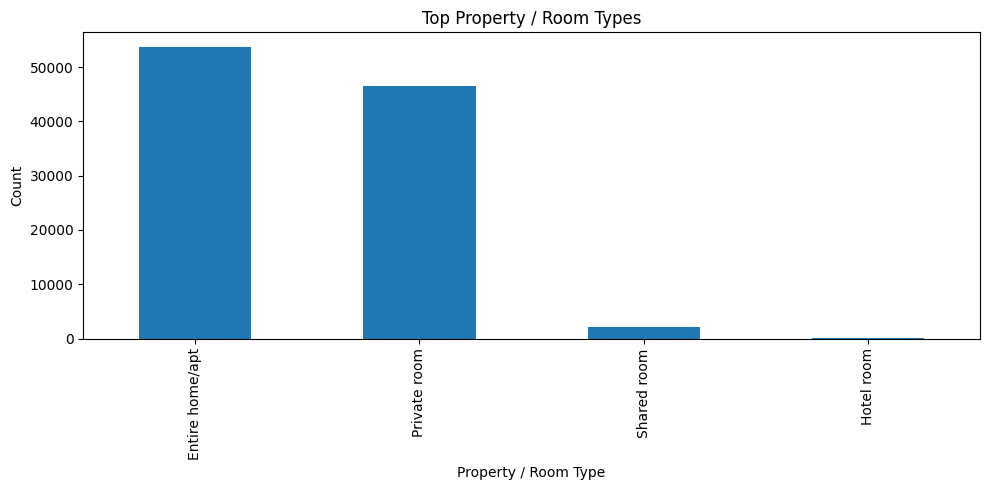

In [7]:
# Q1: What are the different property types in the Dataset?
# Look for common property type columns
ptype_col = find_col(['property_type','room_type','accommodation_type','listing_type'])
if ptype_col is None:
    # fallback: try 'room_type' explicitly
    ptype_col = 'room_type' if 'room_type' in df_clean.columns else None

print('Using column for property type:', ptype_col)
if ptype_col:
    prop_counts = df_clean[ptype_col].value_counts(dropna=False)
    display(prop_counts.head(50))
    # Plot
    plt.figure(figsize=(10,5))
    prop_counts.head(20).plot(kind='bar')
    plt.title('Top Property / Room Types')
    plt.xlabel('Property / Room Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('No property type column detected.')

neighborhood-group column: neighbourhood_group
neighbourhood column: neighbourhood_group


,count
neighbourhood_group,
Manhattan,43792
Brooklyn,41842
Queens,13267
Bronx,2712
Staten Island,955
brookln,1
manhatan,1


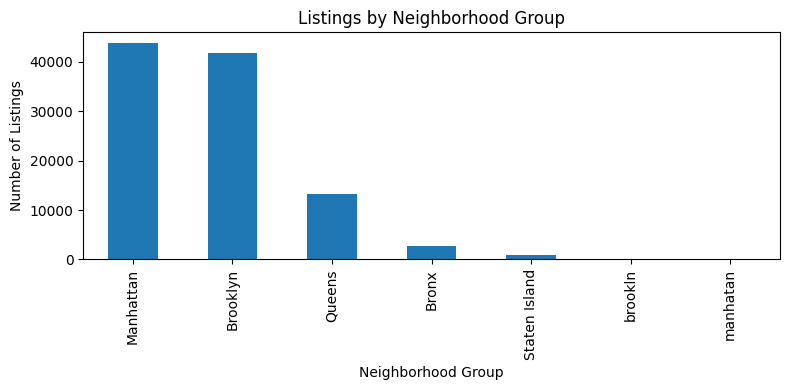

In [8]:
# Q2: Which neighborhood group has the highest number of listings?
# Use neighborhood_col or neighbourhood_col or 'neighbourhood_group'
ng_col = neighborhood_col if neighborhood_col in df_clean.columns else find_col(['neighbourhood_group','neighborhood_group','neighborhood_group'])
n_col = neighbourhood_col if neighbourhood_col in df_clean.columns else find_col(['neighbourhood','neighborhood_cleansed','neighbourhood_cleansed','neighborhood'])

print('neighborhood-group column:', ng_col)
print('neighbourhood column:', n_col)

if ng_col:
    ng_counts = df_clean[ng_col].value_counts()
    display(ng_counts)
    plt.figure(figsize=(8,4))
    ng_counts.plot(kind='bar')
    plt.title('Listings by Neighborhood Group')
    plt.xlabel('Neighborhood Group')
    plt.ylabel('Number of Listings')
    plt.tight_layout()
    plt.show()
else:
    print('No neighborhood group column detected; using neighbourhood counts.')
    if n_col:
        n_counts = df_clean[n_col].value_counts().head(20)
        display(n_counts)
        plt.figure(figsize=(12,4))
        n_counts.plot(kind='bar')
        plt.title('Top 20 Neighborhoods by Listings')
        plt.xlabel('Neighborhood')
        plt.ylabel('Number of Listings')
        plt.tight_layout()
        plt.show()

,price
neighbourhood_group,
Queens,630.207647
Bronx,627.766359
Brooklyn,626.562193
Staten Island,624.490546
Manhattan,622.440227
brookln,580.000000
manhatan,460.000000


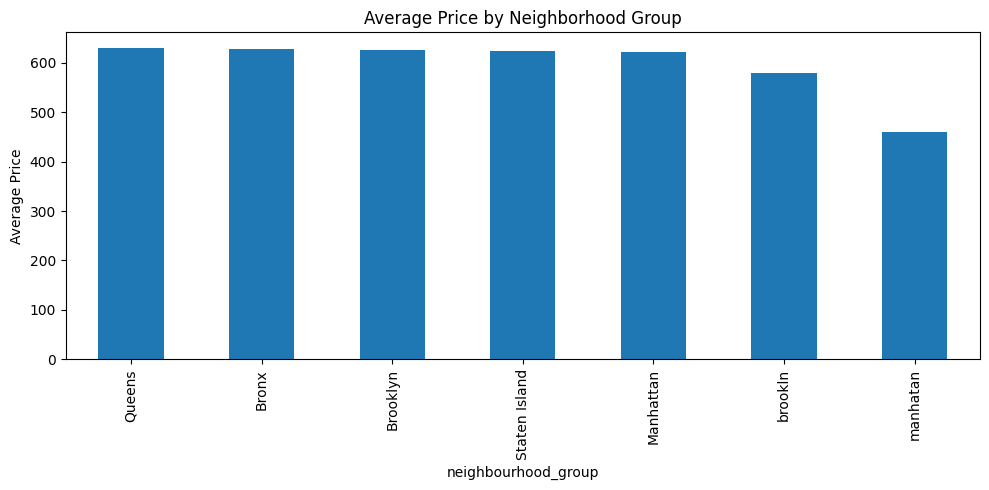

In [9]:
# Q3: Which neighborhood group have the highest average prices for Airbnb listings?
if price_col is None:
    print('Price column not detected; cannot compute prices.')
else:
    group_col = ng_col if ng_col else n_col
    if group_col:
        price_by_group = df_clean.groupby(group_col)[price_col].mean().sort_values(ascending=False)
        display(price_by_group.head(20))
        plt.figure(figsize=(10,5))
        price_by_group.head(20).plot(kind='bar')
        plt.title('Average Price by Neighborhood Group')
        plt.ylabel('Average Price')
        plt.tight_layout()
        plt.show()
    else:
        print('No grouping column detected for neighborhoods.')

Detected year-like column: construction_year


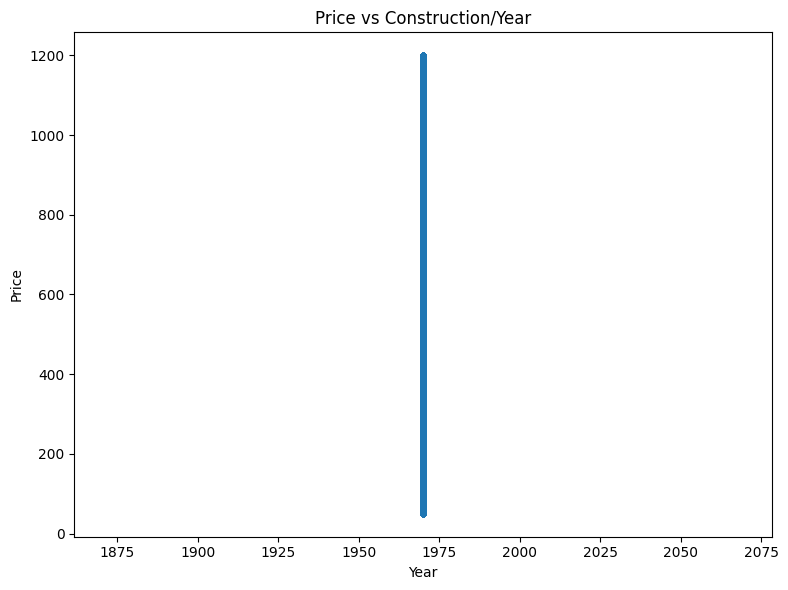

Pearson correlation: nan, p-value: nan


In [10]:
# Q4: Is there a relationship between the construction year of property and price?
# Try to find a 'year' column or 'construction_year' or 'host_since' or 'first_review' etc.
year_col = find_col(['construction_year','year_built','year','built','host_since','first_review','first_review_date'])
print('Detected year-like column:', year_col)
if year_col and price_col:
    yc = df_clean[year_col]
    if np.issubdtype(yc.dtype, np.datetime64):
        df_clean['_year_extracted'] = yc.dt.year
    else:
        df_clean['_year_extracted'] = pd.to_numeric(yc, errors='coerce')
    sub = df_clean.dropna(subset=['_year_extracted', price_col])
    if len(sub) == 0:
        print('No rows with both year and price available.')
    else:
        plt.figure(figsize=(8,6))
        plt.scatter(sub['_year_extracted'], sub[price_col], alpha=0.4, s=10)
        plt.title('Price vs Construction/Year')
        plt.xlabel('Year')
        plt.ylabel('Price')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.tight_layout()
        plt.show()
        # Correlation
        if len(sub) > 10:
            corr, p = pearsonr(sub['_year_extracted'].astype(float), sub[price_col].astype(float))
            print(f'Pearson correlation: {corr:.4f}, p-value: {p:.4g}')
        else:
            print('Not enough data points with both year and price.')
else:
    print('No suitable year-like column or price column found.')

In [11]:
# Q5: Who are the top 10 hosts by calculated host listing count?
host_listings_col = host_listings_count_col if host_listings_count_col in df_clean.columns else find_col(['calculated_host_listings_count','host_listings_count','host_listings'])
host_name_col = host_name_col if host_name_col in df_clean.columns else find_col(['host_name','host'])
host_id_col = host_id_col if host_id_col in df_clean.columns else find_col(['host_id','hostid'])

print('Using host listings col:', host_listings_col)
if host_listings_col and (host_name_col or host_id_col):
    cols = [c for c in [host_id_col, host_name_col, host_listings_col] if c]
    top_hosts = df_clean[cols].drop_duplicates().sort_values(by=host_listings_col, ascending=False).head(10)
    display(top_hosts)
else:
    # Fallback: compute counts per host id/name
    by = None
    if host_id_col and host_id_col in df_clean.columns:
        by = host_id_col
    elif host_name_col and host_name_col in df_clean.columns:
        by = host_name_col
    if by:
        top_hosts = df_clean.groupby(by).size().sort_values(ascending=False).head(10)
        display(top_hosts)
        print('\nIf you want host names as well, ensure host_name and host_id columns exist.')
    else:
        print('No host identifier columns detected.')

Using host listings col: calculated_host_listings_count


,host_id,host_name,calculated_host_listings_count
59511,8674093918,Blueground,332.0
66463,97620664846,Blueground,332.0
57424,76431087156,Blueground,332.0
64830,87944211655,Blueground,332.0
64894,52360647654,Blueground,332.0
60834,52760110374,Blueground,332.0
60829,87920381104,Blueground,332.0
63698,3190103639,Blueground,332.0
65123,62221516723,Blueground,332.0
63596,94944787862,Blueground,332.0


In [12]:
# Q6: Are hosts with verified identities more likely to receive positive reviews?
verified_col = find_col(['host_identity_verified','identity_verified','host_verifications','verified'])
review_col = find_col(['review_scores_rating','review_score','review_scores','review_scores_rating'])

print('verified_col ->', verified_col)
print('review_col ->', review_col)

if verified_col and review_col and verified_col in df_clean.columns:
    tmp = df_clean[[verified_col, review_col]].copy()
    tmp[verified_col] = tmp[verified_col].astype(str).str.lower().isin(['true','yes','y','t','verified','1'])
    grp = tmp.groupby(verified_col)[review_col].agg(['count','mean','median']).sort_values('mean', ascending=False)
    display(grp)
    plt.figure(figsize=(6,4))
    grp['mean'].plot(kind='bar')
    plt.title('Average Review Score by Host Identity Verified')
    plt.ylabel('Average Review Score')
    plt.tight_layout()
    plt.show()
else:
    print('Required columns for verification or review score not detected.')

verified_col -> host_identity_verified
review_col -> None
Required columns for verification or review score not detected.


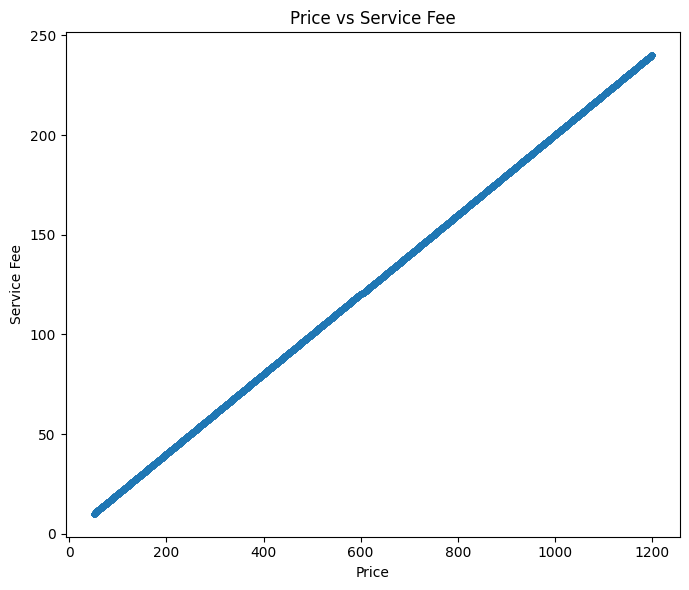

Pearson correlation: 1.0000, p-value: 0


In [13]:
# Q7: correlation between price and service fee
if price_col and service_fee_col:
    tmp = df_clean[[price_col, service_fee_col]].dropna()
    plt.figure(figsize=(7,6))
    plt.scatter(tmp[price_col], tmp[service_fee_col], s=8, alpha=0.4)
    plt.title('Price vs Service Fee')
    plt.xlabel('Price')
    plt.ylabel('Service Fee')
    plt.tight_layout()
    plt.show()
    if len(tmp) > 10:
        corr, p = pearsonr(tmp[price_col].astype(float), tmp[service_fee_col].astype(float))
        print(f'Pearson correlation: {corr:.4f}, p-value: {p:.4g}')
else:
    print('Price or service fee columns not available.')

In [14]:
# Q8: Average review rating by neighborhood group and room type
room_type_col = find_col(['room_type','roomtype','room_type'])
rating_col = review_col

if rating_col and (ng_col or n_col) and room_type_col:
    group_col = ng_col if ng_col else n_col
    pivot = df_clean.pivot_table(values=rating_col, index=group_col, columns=room_type_col, aggfunc='mean')
    display(pivot.head(20))
    top_groups = pivot.mean(axis=1).sort_values(ascending=False).head(10).index.tolist()
    subset = pivot.loc[top_groups]
    subset.plot(kind='bar', figsize=(12,6))
    plt.title('Average Review Rating by Neighborhood Group and Room Type (Top Groups)')
    plt.ylabel('Average Rating')
    plt.tight_layout()
    plt.show()
else:
    print('Required columns (rating, neighborhood, room type) not all present.')

Required columns (rating, neighborhood, room type) not all present.


availability_col -> availability_365 host_listings_col -> calculated_host_listings_count


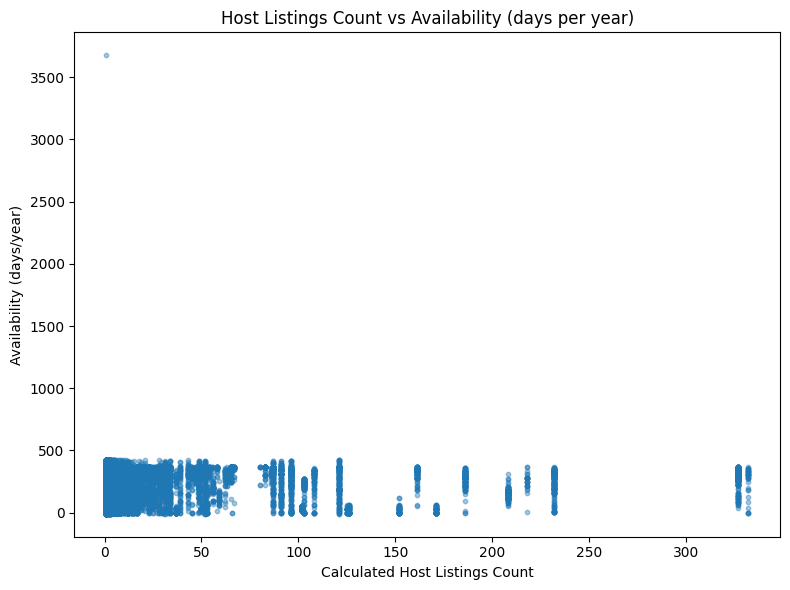

,count,mean,median
_bucket,,,
"(0.999, 3.0]",84071,123.773215,77.0
"(3.0, 332.0]",17761,223.051968,255.0


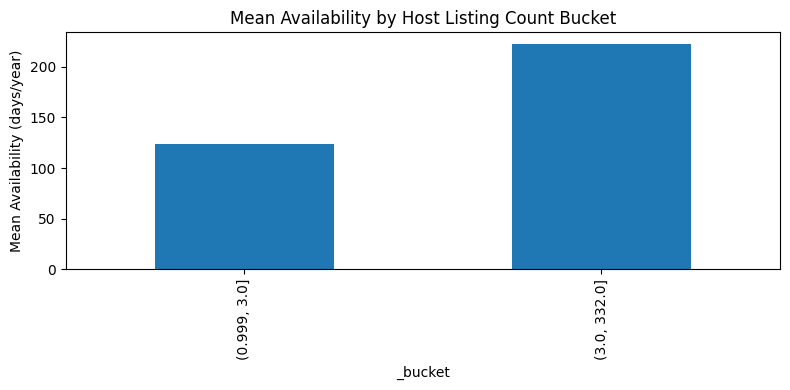

In [15]:
# Q9: host listings count vs availability
availability_col = find_col(['availability_365','availability','availability_30','availability_365'])
print('availability_col ->', availability_col, 'host_listings_col ->', host_listings_col)

if host_listings_col and availability_col and host_listings_col in df_clean.columns and availability_col in df_clean.columns:
    tmp = df_clean[[host_listings_col, availability_col]].dropna()
    plt.figure(figsize=(8,6))
    plt.scatter(tmp[host_listings_col], tmp[availability_col], s=10, alpha=0.4)
    plt.title('Host Listings Count vs Availability (days per year)')
    plt.xlabel('Calculated Host Listings Count')
    plt.ylabel('Availability (days/year)')
    plt.tight_layout()
    plt.show()
    tmp['_bucket'] = pd.qcut(tmp[host_listings_col], q=min(5,len(tmp[host_listings_col].unique())), duplicates='drop')
    agg = tmp.groupby('_bucket')[availability_col].agg(['count','mean','median'])
    display(agg)
    plt.figure(figsize=(8,4))
    agg['mean'].plot(kind='bar')
    plt.title('Mean Availability by Host Listing Count Bucket')
    plt.ylabel('Mean Availability (days/year)')
    plt.tight_layout()
    plt.show()
else:
    print('Required availability or host listings count columns not present.')